# Evaluation of single cell detectors

Evaluation is done based on:
- Evaluation dataset
- Different confluencys
- Generalization on new cell lines

____

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

import cv2

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Own scripts
from data import tf_record_loading, bbox_utils
from prediction import simple_confluency, prediction_utils
from statistics import get_performance_metrics

In [2]:
# Set default figure size
matplotlib.rcParams['figure.figsize'] = (12, 6)

____

**HELPER FUNCTIONS**

In [3]:
def evaluate_on_series(model, data, iou=0.5):
    """
    Get evaluation metrics on all images in data
    
    :param model: tf_model
    :param data: list/generator of dict with keys: ["name(s)", "image(s)", "bboxes"]
    :return: list of dict with metrics
    """
    metrics = []

    for query in data:
        image = query.get("image")
        gt_boxes = query.get("bboxes")

        pred_boxes = prediction_utils.run_inference_for_single_image(model, image)
        pred_boxes = pred_boxes.get("detection_boxes")
        metrics.append(get_performance_metrics(pred_boxes, gt_boxes, iou=iou))
    
    return metrics

##  Setup model and data path 

In [4]:
# Model should be exported tensorflow model. (Must contain: saved_model subfolder, model.ckpt, frozen_inference_graph)
LF_MODEL_PATH = Path(r"D:\Nabil_object_detection\models\graph_imgSize_vs_bboxSize\ssd_resnet50_v1_fpn_z00_tiles0_bboxes40")

# TF Records as generated by data.tf_record_writer. data.tf_dataset_generator(laod_tf_dataset) will produce keys: ["name(s)", "image(s)", "bboxes"]
LF_DATA_PATH = Path(r"D:\Nabil_object_detection\val\z00_tiles0_bboxes40.tfrecord")
BF_DATA_PATH = Path(r"D:\Nabil_object_detection\val\10x_tiles0_bboxes40.tfrecord") # Needed for confluency prediction

# Perfomance on validation data

In [5]:
val_data_generator = tf_record_loading.tf_dataset_generator(LF_DATA_PATH)
model = prediction_utils.load_model(LF_MODEL_PATH)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [6]:
metrics = evaluate_on_series(model, val_data_generator)

In [7]:
# Show all measured metrics. For defeinition see: https://en.wikipedia.org/wiki/Receiver_operating_characteristic

print(metrics[0].keys())

aucs = [i.get("auc") for i in metrics]
fdrs = [i.get("fdr") for i in metrics]
fnrs = [i.get("fnr") for i in metrics]

dict_keys(['tp', 'fn', 'fp', 'recall', 'precision', 'recalls', 'precisions', 'fnr', 'fdr', 'map', 'auc'])


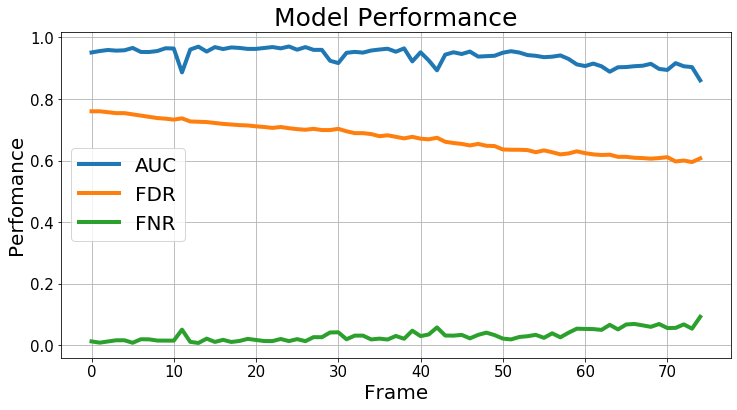

In [8]:
frames = list(range(len(aucs)))
sns.lineplot(frames, aucs, lw=4, label="AUC")
sns.lineplot(frames, fdrs, lw=4, label="FDR")
sns.lineplot(frames, fnrs, lw=4, label="FNR")
plt.title("Model Performance", fontsize=25)
plt.xlabel("Frame", fontsize=20)
plt.ylabel("Perfomance", fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend(fontsize=20)
plt.grid()

# Evaluation on different confluencys

In [9]:
# Reload data generator. Must be brightfield, because confluency detection is based on simple filters.
val_data_generator = tf_record_loading.tf_dataset_generator(BF_DATA_PATH)

In [10]:
confluencys = [simple_confluency.get_image_confluency(x.get("image")) for x in val_data_generator]

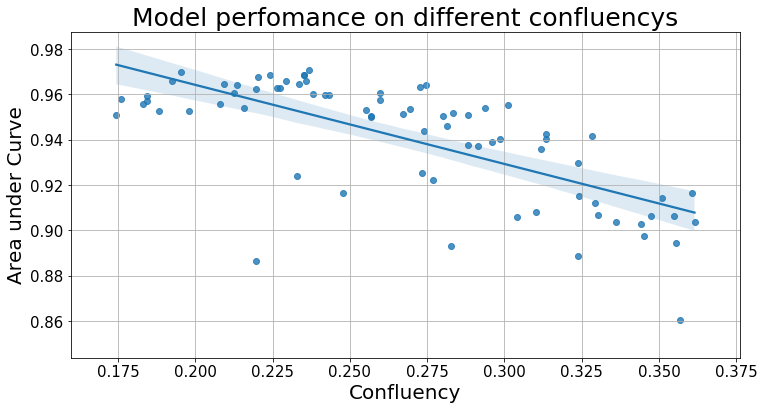

In [11]:
sns.regplot(confluencys, aucs)
plt.title("Model perfomance on different confluencys", fontsize=25)
plt.xlabel("Confluency", fontsize=20)
plt.ylabel("Area under Curve", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()